In [62]:
cd /home/dmoi/projects/foldtree2/

/home/dmoi/projects/foldtree2


In [63]:
import sys
sys.path.append('/home/dmoi/projects/foldtree2')
#read the afdb clusters file
import pandas as pd
import numpy as np
import glob
import os
#autoreload
import pickle
from src import AFDB_tools
import toytree
import tqdm
from matplotlib import pyplot as plt
import torch
from converter import pdbgraph
converter = pdbgraph.PDB2PyG()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [64]:
modelname = 'small5_geo_graph'

with open( modelname + '.pkl', 'rb') as f:
	encoder, decoder = pickle.load(f)

encoder.eval()
decoder.eval()	
encoder.to(device)
decoder.to(device)

HeteroGAE_Decoder(
  (convs): ModuleList(
    (0-4): 5 x HeteroConv(num_relations=2)
  )
  (norms): ModuleList(
    (0-4): 5 x LayerNorm((50,), eps=1e-05, elementwise_affine=True)
  )
  (bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn_foldx): BatchNorm1d(23, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout): Dropout(p=0.001, inplace=False)
  (jk): JumpingKnowledge(cat)
  (sigmoid): Sigmoid()
  (lin): Sequential(
    (0): LayerNorm((250,), eps=1e-05, elementwise_affine=True)
    (1): Linear(in_features=250, out_features=400, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=400, out_features=400, bias=True)
    (4): GELU(approximate='none')
    (5): LayerNorm((400,), eps=1e-05, elementwise_affine=True)
  )
  (aadecoder): Sequential(
    (0): Linear(in_features=420, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=200, out_features=100, bias=True)
    (3):

In [65]:
from torch_geometric.data import DataLoader , HeteroData

struct_dat = pdbgraph.StructureDataset('structalignmk4.h5')
#struct_dat = ft2.StructureDataset('structs_training.h5')
encoder_loader = DataLoader(struct_dat, batch_size=1, shuffle=True)
#encode the structures
encode_alns = True
if encode_alns == True:
	def databatch2list(loader , limit = 10):
		for i,data in enumerate(loader):
			if i > limit:
				break
			data = data.to_data_list()
			for d in data:
				d = d.to(device)
				yield d
	encoder_loader = databatch2list(encoder_loader)
	encoder.encode_structures_fasta(encoder_loader , modelname+'_aln_encoded_test.fasta' )

/home/dmoi/miniforge3/envs/pyg/lib/python3.12/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
11it [00:00, 18.66it/s]


In [66]:
encoded_fasta =  modelname+'_aln_encoded_test.fasta' 
seqstr = ''
ID = ''
seqdict = {}
with open(encoded_fasta, 'r') as f:
	#read all chars of file into a string
	for line in tqdm.tqdm(f):
		if line[0] == '>' and line[-1] == '\n':
			seqdict[ID] = seqstr
			ID = line[1:].strip()
			seqstr = ''
		else:
			seqstr += line.strip()
del seqdict['']
encoded_df = pd.DataFrame( seqdict.items() , columns=['protid', 'seq'] )
#change index to protid
encoded_df.index = encoded_df.protid
encoded_df = encoded_df.drop( 'protid', axis=1 )

encoded_df['ord'] = encoded_df.seq.map( lambda x: [ ord(c) for c in x] )
#hex starts at 1
encoded_df['hex2'] = encoded_df.ord.map( lambda x: [ hex(c) for c in x] )

51it [00:00, 140452.73it/s]


In [67]:
charset = 249
#make fasta is shifted by 1 and goes from 1-248 included
#0x01 – 0xFF excluding > (0x3E), = (0x3D), < (0x3C), - (0x2D), Space (0x20), Carriage Return (0x0d) and Line Feed (0x0a)
#replace 0x22 or " which is necesary for nexus files and 0x23 or # which is also necesary

replace_dict = {chr(0):chr(246) , '"':chr(248) , '#':chr(247), '>' : chr(249), '=' : chr(250), '<' : chr(251), '-' : chr(252), ' ' : chr(253) , '\r' : chr(254), '\n' : chr(255) }
rev_replace_dict = { v:k for k,v in replace_dict.items() }

replace_dict_ord = { ord(k):ord(v) for k,v in replace_dict.items() }
rev_replace_dict_ord = { ord(v):ord(k) for k,v in replace_dict.items() }

print(replace_dict)
print(rev_replace_dict)

print( replace_dict_ord )

print(rev_replace_dict_ord)

{'\x00': 'ö', '"': 'ø', '#': '÷', '>': 'ù', '=': 'ú', '<': 'û', '-': 'ü', ' ': 'ý', '\r': 'þ', '\n': 'ÿ'}
{'ö': '\x00', 'ø': '"', '÷': '#', 'ù': '>', 'ú': '=', 'û': '<', 'ü': '-', 'ý': ' ', 'þ': '\r', 'ÿ': '\n'}
{0: 246, 34: 248, 35: 247, 62: 249, 61: 250, 60: 251, 45: 252, 32: 253, 13: 254, 10: 255}
{246: 0, 248: 34, 247: 35, 249: 62, 250: 61, 251: 60, 252: 45, 253: 32, 254: 13, 255: 10}


In [68]:
encoded_df.seq = encoded_df.seq.map(lambda x : ''.join([ c if c not in replace_dict else replace_dict[c] for c in x]))
print(encoded_df)

                                                          seq  \
protid                                                          
A0A6G0WDL6  øø''÷÷÷÷ýý(÷ý((...   
A0A842PGQ3  (&&&&&&&'ýýý&&÷÷÷÷÷ý÷÷'...   
A0A413BF39  '''''(÷÷÷÷÷ý(...   
I6YA87      '''''&ý(&&'...   
R7IBJ8      ''''''''((...   
A0A5Q4FSG5  ÷÷ý÷÷ý÷÷ýý÷ýý÷÷ý÷÷÷ý&ýý÷÷...   
A0A1C7PEK0  ''''ý÷ý'÷ý÷÷÷÷÷...   
A0A5R8KJ52  ''÷&ý÷÷÷÷÷÷÷ý÷÷÷...   
A0A3M2M7Y1  '''øøý...   
A0A7T8RW27  ''&&&&&&'(((((((((...   

                                                          ord  \
protid                                                          
A0A6G0WDL6  [34, 34, 12, 12, 39, 12, 12, 12, 12, 12, 8, 8,...   
A0A842PGQ3  [16, 40, 19, 16, 6, 38, 38, 38

In [69]:
import py3Dmol

def view_custom_pdb(pdb_file, chain='A'):
	"""
	Visualize a PDB structure from a file, highlight a specific residue with thicker sticks,
	show the backbone for the selected residue, and add an arrow-like indicator.
	
	Parameters:
	- pdb_file: str, path to the local PDB file.
	- residue_num: int, residue number to highlight.
	- chain: str, the chain identifier (default 'A').
	"""
	# Read the PDB file content
	with open(pdb_file, 'r') as f:
		pdb_content = f.read()

	# Initialize py3Dmol viewer
	viewer = py3Dmol.view(width=800, height=600)
	
	# Add the PDB structure to the viewer
	viewer.addModel(pdb_content, 'pdb')
	
	# Apply cartoon style for the overall structure
	viewer.setStyle({'cartoon': {'color': 'cyan'}})
	
	
	# Add molecular surface for the rest of the structure
	viewer.addSurface(py3Dmol.VDW, {'opacity': 0.5})
	
	
	# Set zoom and background color
	viewer.zoomTo()
	viewer.setBackgroundColor('white')
	
	# Show the structure
	return viewer.show()



A0A6G0WDL6


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

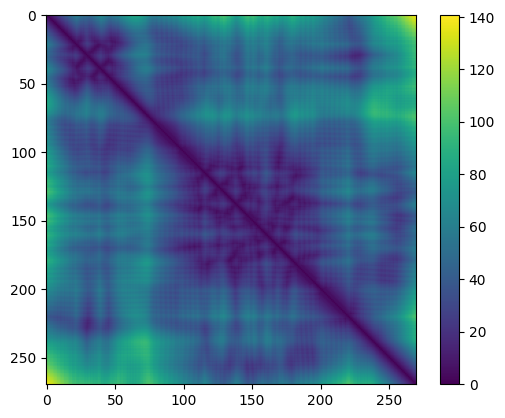

269
torch.Size([269, 20])
HeteroData(
  res={
    x=[269, 20],
    batch=[269],
  },
  positions={ x=[269, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 268] },
  (res, backbone_rev, res)={ edge_index=[2, 268] },
  (godnode4decoder, informs, res)={ edge_index=[2, 269] },
  (res, informs, godnode4decoder)={ edge_index=[2, 269] },
  (res, informs, godnode)={ edge_index=[2, 269] }
)
torch.Size([72361])
tensor([[-2.6893, -3.3199, -4.5859,  ..., -3.8077, -3.2577, -1.8494],
        [-3.1134, -3.6595, -5.1856,  ..., -3.7565, -3.2519, -1.8548],
        [-2.7342, -2.6438, -2.4424,  ..., -7.7351, -5.7901, -5.5085],
        ...,
        [-2.8362, -2.6227, -2.3231,  ..., -7.1373, -6.0806, -5.4152],
        [-1.8913, -2.6165, -4.3014,  ..., -4.8801, -3.3836, -2.0867],
        [-3.4209, -3.3122, -2.7073,  ..., -7.0462, -5.7856, -5.7715]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ...,

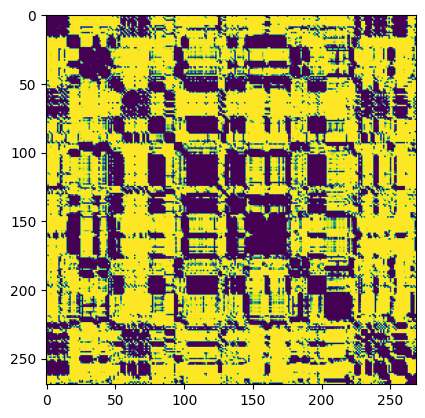

torch.Size([269, 269])
(270, 270)


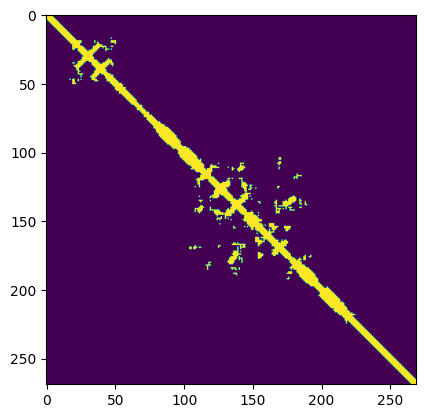

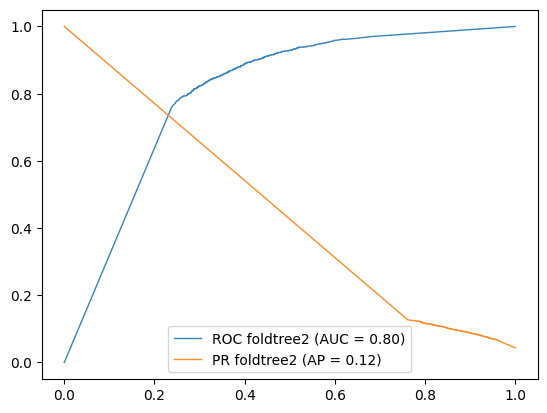

A0A842PGQ3


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

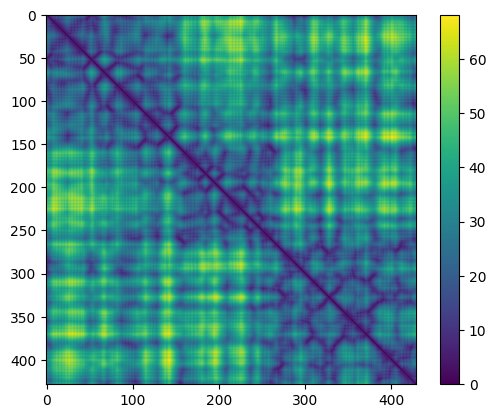

422
torch.Size([422, 20])
HeteroData(
  res={
    x=[422, 20],
    batch=[422],
  },
  positions={ x=[422, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 421] },
  (res, backbone_rev, res)={ edge_index=[2, 421] },
  (godnode4decoder, informs, res)={ edge_index=[2, 422] },
  (res, informs, godnode4decoder)={ edge_index=[2, 422] },
  (res, informs, godnode)={ edge_index=[2, 422] }
)
torch.Size([178084])
tensor([[-2.5624, -3.1406, -4.4836,  ..., -3.7346, -3.0367, -1.9322],
        [-1.6524, -2.1204, -3.1184,  ..., -5.1942, -3.7344, -3.3035],
        [-1.9833, -2.0382, -3.0245,  ..., -6.5888, -4.5765, -4.4308],
        ...,
        [-1.9569, -1.9300, -3.4192,  ..., -5.8467, -3.9330, -3.1254],
        [-3.0912, -3.7547, -5.0763,  ..., -3.4488, -3.1745, -1.7276],
        [-2.1656, -1.9470, -2.6593,  ..., -7.7560, -5.4696, -5.8654]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ...

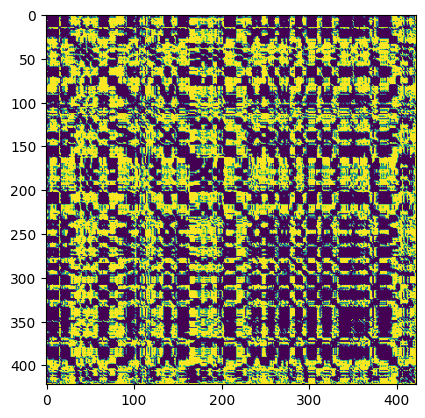

torch.Size([422, 422])
(429, 429)


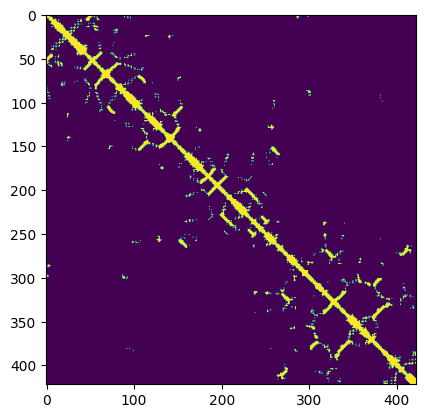

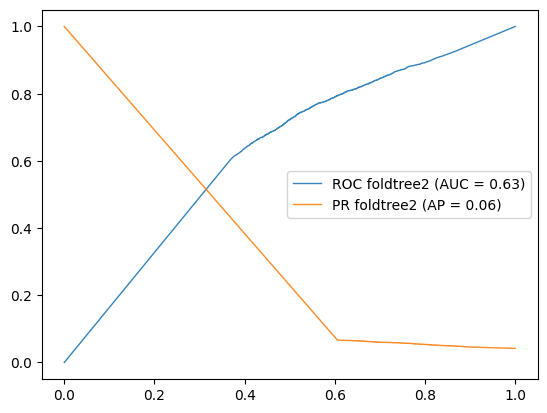

A0A413BF39


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

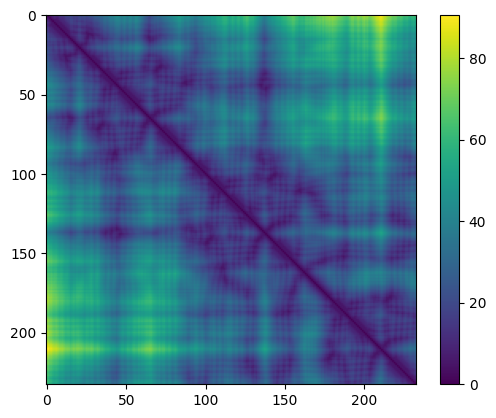

220
torch.Size([220, 20])
HeteroData(
  res={
    x=[220, 20],
    batch=[220],
  },
  positions={ x=[220, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 219] },
  (res, backbone_rev, res)={ edge_index=[2, 219] },
  (godnode4decoder, informs, res)={ edge_index=[2, 220] },
  (res, informs, godnode4decoder)={ edge_index=[2, 220] },
  (res, informs, godnode)={ edge_index=[2, 220] }
)
torch.Size([48400])
tensor([[-3.1456, -3.4621, -4.9953,  ..., -3.8277, -2.8012, -1.9934],
        [-2.6413, -2.8783, -4.3524,  ..., -4.3993, -2.9048, -2.3197],
        [-2.5025, -1.9416, -2.4320,  ..., -7.9718, -5.8062, -6.3030],
        ...,
        [-2.5899, -3.1829, -4.7889,  ..., -4.0800, -2.8793, -1.8247],
        [-2.9068, -3.6676, -5.1549,  ..., -3.7534, -2.9729, -1.5865],
        [-3.4209, -3.3122, -2.7073,  ..., -7.0462, -5.7856, -5.7715]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ...,

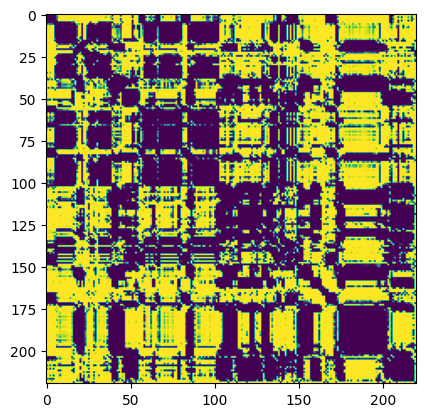

torch.Size([220, 220])
(233, 233)


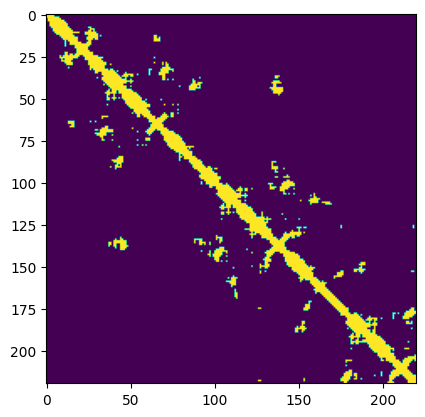

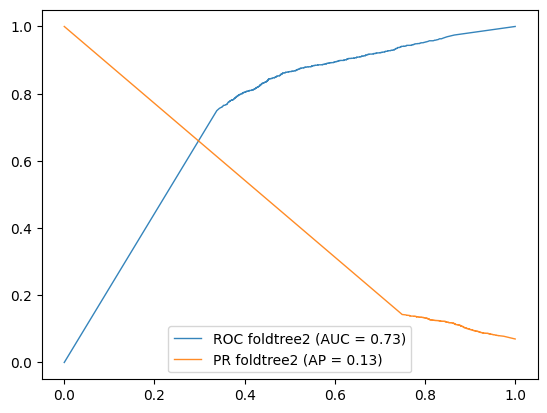

I6YA87


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

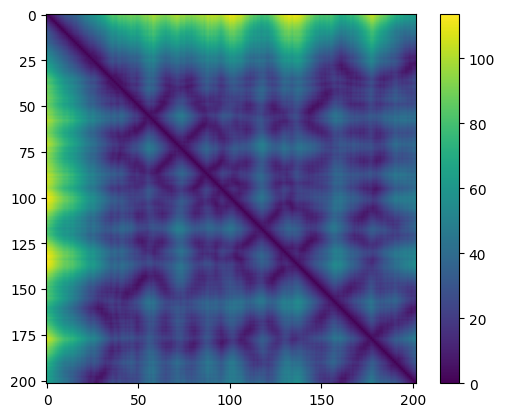

189
torch.Size([189, 20])
HeteroData(
  res={
    x=[189, 20],
    batch=[189],
  },
  positions={ x=[189, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 188] },
  (res, backbone_rev, res)={ edge_index=[2, 188] },
  (godnode4decoder, informs, res)={ edge_index=[2, 189] },
  (res, informs, godnode4decoder)={ edge_index=[2, 189] },
  (res, informs, godnode)={ edge_index=[2, 189] }
)
torch.Size([35721])
tensor([[-2.8257, -3.0605, -4.4767,  ..., -4.1418, -2.7973, -2.2790],
        [-2.9319, -3.2599, -4.6822,  ..., -4.0091, -2.7642, -2.0926],
        [-3.4399, -3.7946, -5.5770,  ..., -3.6469, -2.9386, -1.7993],
        ...,
        [-2.5357, -3.1115, -4.3083,  ..., -3.9526, -2.8925, -2.2398],
        [-2.6807, -3.2246, -4.4905,  ..., -3.9043, -2.8777, -2.1791],
        [-2.7332, -3.3174, -4.7184,  ..., -3.6516, -3.0717, -2.1291]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ...,

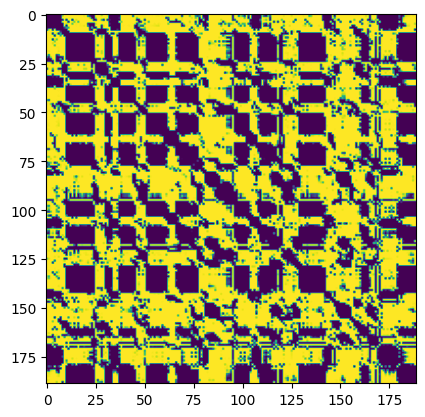

torch.Size([189, 189])
(202, 202)


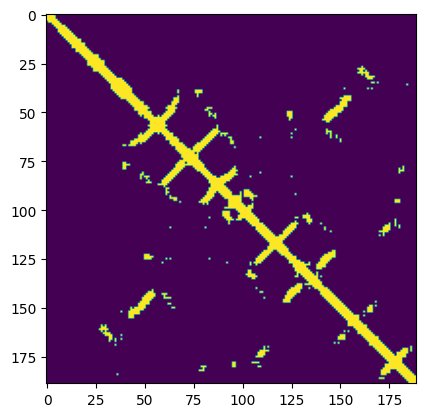

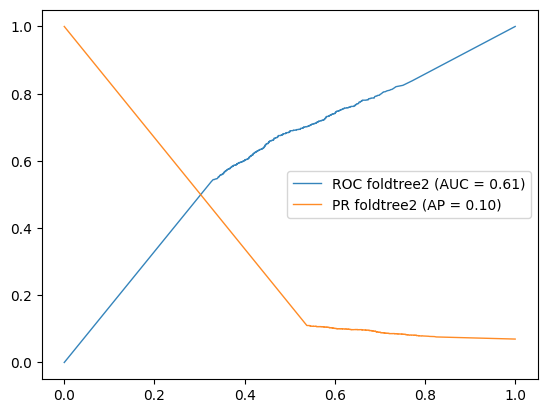

R7IBJ8


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

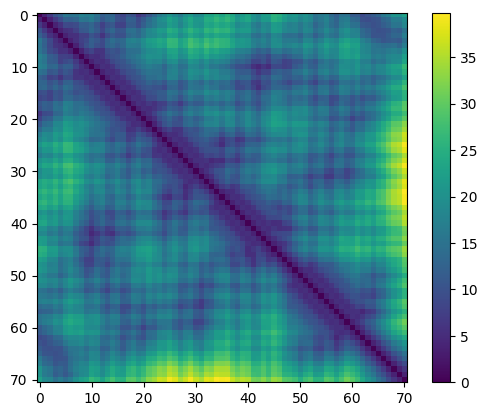

67
torch.Size([67, 20])
HeteroData(
  res={
    x=[67, 20],
    batch=[67],
  },
  positions={ x=[67, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 66] },
  (res, backbone_rev, res)={ edge_index=[2, 66] },
  (godnode4decoder, informs, res)={ edge_index=[2, 67] },
  (res, informs, godnode4decoder)={ edge_index=[2, 67] },
  (res, informs, godnode)={ edge_index=[2, 67] }
)
torch.Size([4489])
tensor([[-2.6279, -2.8484, -4.3247,  ..., -4.4189, -2.9067, -2.3687],
        [-2.5316, -2.0270, -2.3471,  ..., -8.0761, -5.8811, -6.3401],
        [-3.1870, -3.5146, -5.0436,  ..., -3.7946, -2.8026, -1.9606],
        ...,
        [-2.3879, -2.1828, -2.4530,  ..., -8.0416, -5.8762, -5.8247],
        [-2.9952, -2.4711, -2.3725,  ..., -8.1014, -5.9776, -6.0816],
        [-2.1656, -1.9470, -2.6593,  ..., -7.7560, -5.4696, -5.8654]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1., 

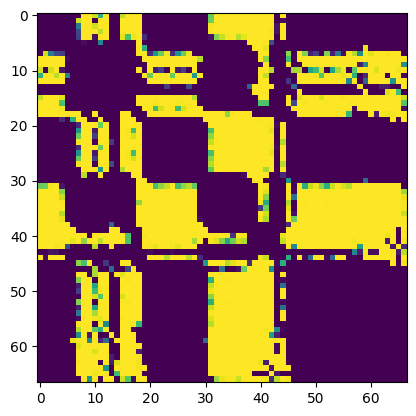

torch.Size([67, 67])
(71, 71)


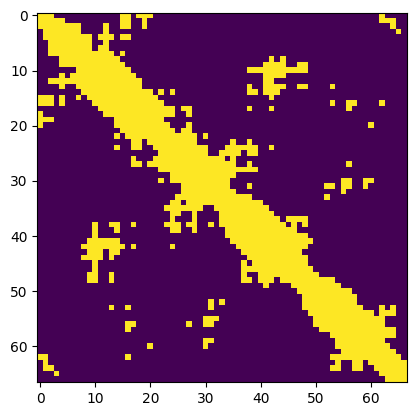

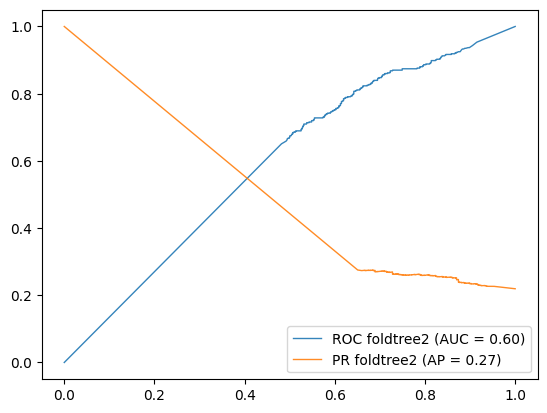

A0A5Q4FSG5


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

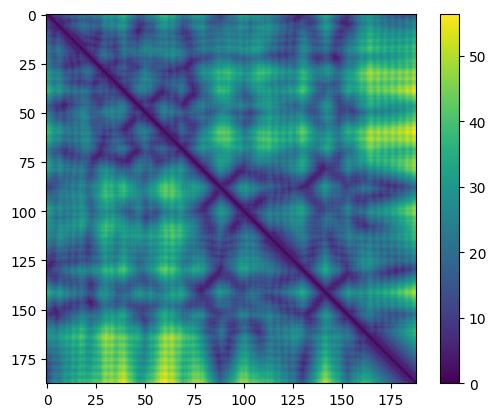

187
torch.Size([187, 20])
HeteroData(
  res={
    x=[187, 20],
    batch=[187],
  },
  positions={ x=[187, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 186] },
  (res, backbone_rev, res)={ edge_index=[2, 186] },
  (godnode4decoder, informs, res)={ edge_index=[2, 187] },
  (res, informs, godnode4decoder)={ edge_index=[2, 187] },
  (res, informs, godnode)={ edge_index=[2, 187] }
)
torch.Size([34969])
tensor([[-3.0131, -3.7133, -4.9128,  ..., -3.3549, -2.9344, -1.8646],
        [-3.1064, -3.9301, -5.1686,  ..., -3.3219, -3.0449, -1.7093],
        [-1.8756, -2.5740, -3.2000,  ..., -4.3481, -3.5180, -3.2783],
        ...,
        [-2.5134, -1.9634, -2.4411,  ..., -7.9577, -5.7833, -6.2628],
        [-2.7912, -3.0545, -4.6461,  ..., -4.2701, -2.8842, -2.0728],
        [-2.1656, -1.9470, -2.6593,  ..., -7.7560, -5.4696, -5.8654]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.0000e+00, 1.0000e+00, 7.5590e-02,  ...,

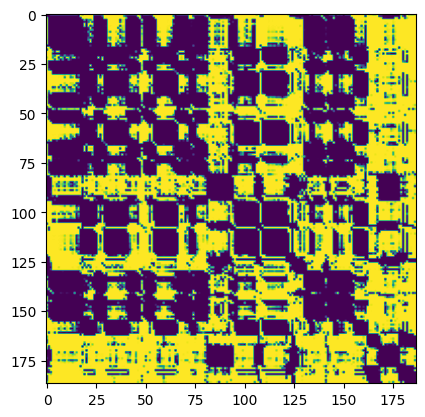

torch.Size([187, 187])
(188, 188)


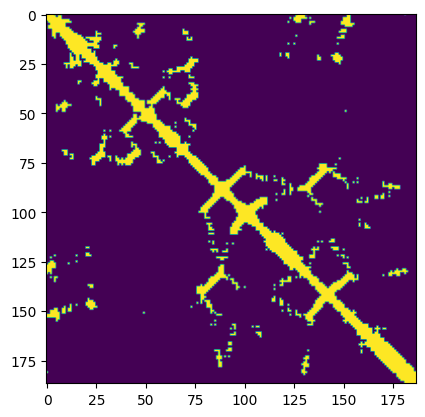

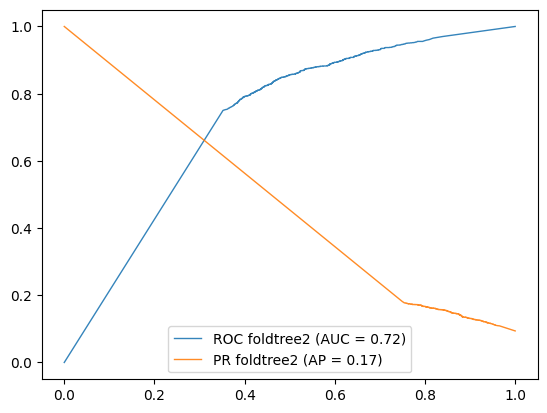

A0A1C7PEK0


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

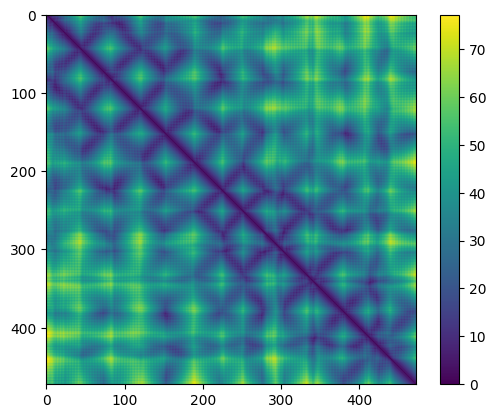

473
torch.Size([473, 20])
HeteroData(
  res={
    x=[473, 20],
    batch=[473],
  },
  positions={ x=[473, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 472] },
  (res, backbone_rev, res)={ edge_index=[2, 472] },
  (godnode4decoder, informs, res)={ edge_index=[2, 473] },
  (res, informs, godnode4decoder)={ edge_index=[2, 473] },
  (res, informs, godnode)={ edge_index=[2, 473] }
)
torch.Size([223729])
tensor([[-3.4460, -3.8088, -5.5121,  ..., -3.6515, -2.9573, -1.7667],
        [-2.4872, -2.7956, -4.4795,  ..., -4.6283, -2.9251, -2.1129],
        [-3.1004, -2.4353, -2.2747,  ..., -8.2760, -6.0480, -6.1298],
        ...,
        [-2.3879, -2.1828, -2.4530,  ..., -8.0416, -5.8762, -5.8247],
        [-2.9952, -2.4711, -2.3725,  ..., -8.1014, -5.9776, -6.0816],
        [-2.1656, -1.9470, -2.6593,  ..., -7.7560, -5.4696, -5.8654]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [

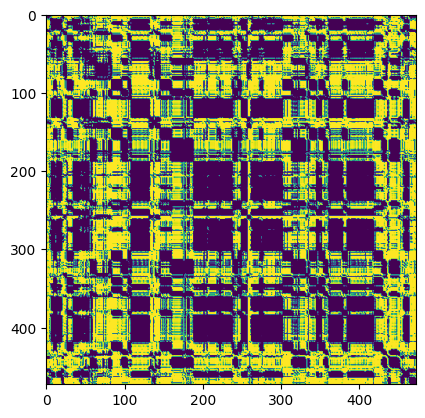

torch.Size([473, 473])
(473, 473)


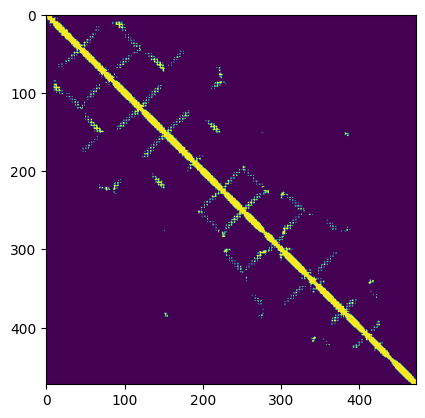

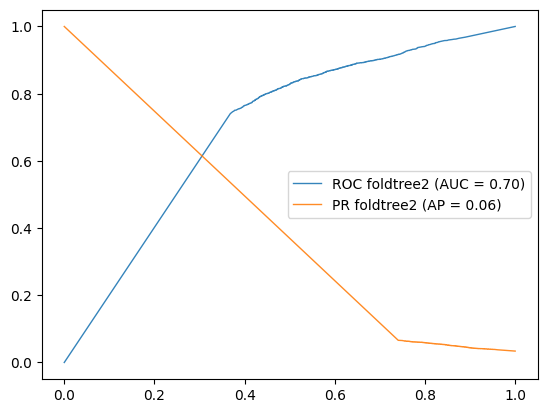

A0A5R8KJ52


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

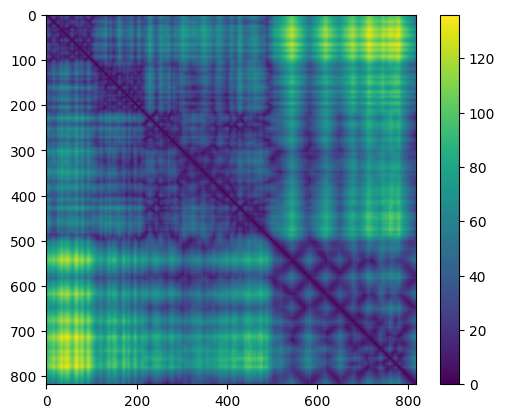

812
torch.Size([812, 20])
HeteroData(
  res={
    x=[812, 20],
    batch=[812],
  },
  positions={ x=[812, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 811] },
  (res, backbone_rev, res)={ edge_index=[2, 811] },
  (godnode4decoder, informs, res)={ edge_index=[2, 812] },
  (res, informs, godnode4decoder)={ edge_index=[2, 812] },
  (res, informs, godnode)={ edge_index=[2, 812] }
)
torch.Size([659344])
tensor([[-3.6381, -3.9385, -5.7602,  ..., -3.5191, -3.1458, -1.6567],
        [-3.4444, -3.7331, -5.5973,  ..., -3.7123, -3.3079, -1.6502],
        [-2.3940, -2.7909, -2.5868,  ..., -7.4606, -5.6511, -5.0768],
        ...,
        [-3.0993, -3.8012, -5.2193,  ..., -3.4839, -3.0699, -1.8121],
        [-3.4568, -4.0089, -5.5861,  ..., -3.4387, -3.0650, -1.6748],
        [-2.1656, -1.9470, -2.6593,  ..., -7.7560, -5.4696, -5.8654]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.0000e+00, 1.0000e+00, 2.1919e-02,  ...

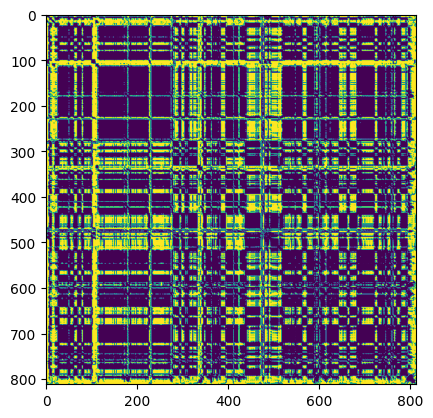

torch.Size([812, 812])
(818, 818)


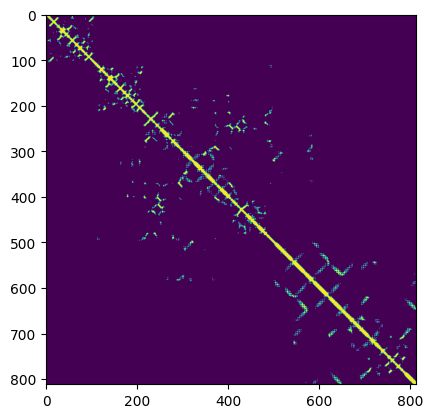

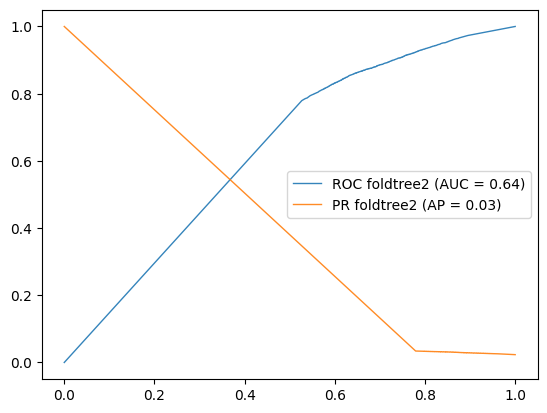

A0A3M2M7Y1


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

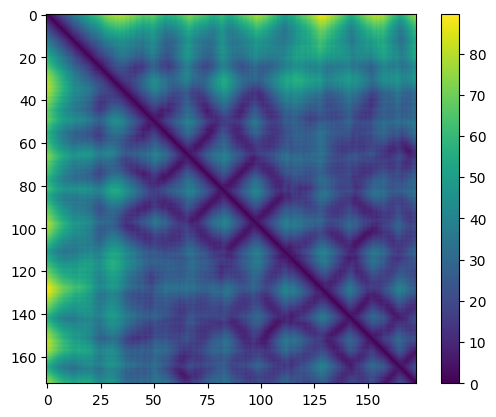

167
torch.Size([167, 20])
HeteroData(
  res={
    x=[167, 20],
    batch=[167],
  },
  positions={ x=[167, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 166] },
  (res, backbone_rev, res)={ edge_index=[2, 166] },
  (godnode4decoder, informs, res)={ edge_index=[2, 167] },
  (res, informs, godnode4decoder)={ edge_index=[2, 167] },
  (res, informs, godnode)={ edge_index=[2, 167] }
)
torch.Size([27889])
tensor([[-3.1646, -3.4981, -5.0108,  ..., -3.8027, -2.7922, -1.9719],
        [-3.1632, -3.4950, -5.1537,  ..., -3.8807, -2.8456, -1.8585],
        [-2.4571, -1.9454, -2.3836,  ..., -8.1149, -5.9228, -6.2948],
        ...,
        [-2.2292, -2.7131, -2.7664,  ..., -5.0592, -4.1181, -4.1158],
        [-1.8729, -2.6648, -3.4736,  ..., -3.7722, -3.1013, -2.5969],
        [-2.7689, -3.6931, -4.6777,  ..., -3.2431, -2.9639, -1.8055]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ...,

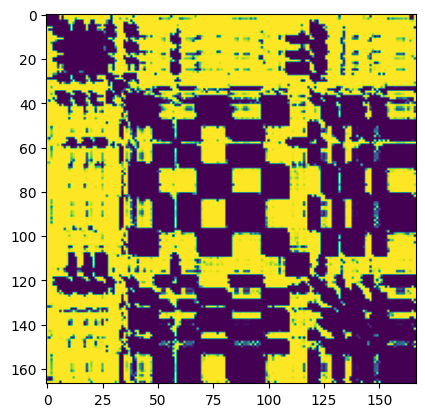

torch.Size([167, 167])
(173, 173)


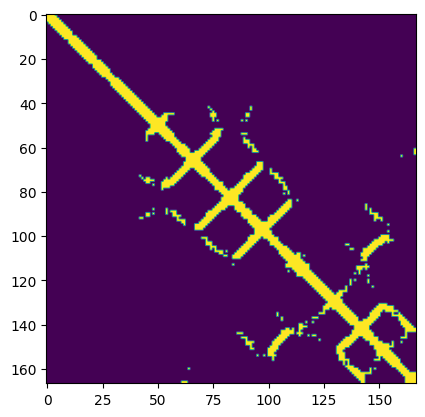

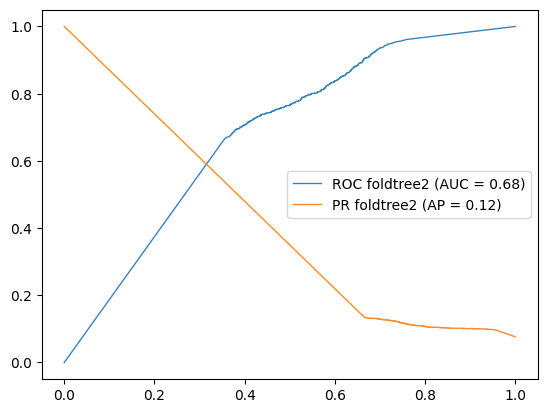

A0A7T8RW27


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

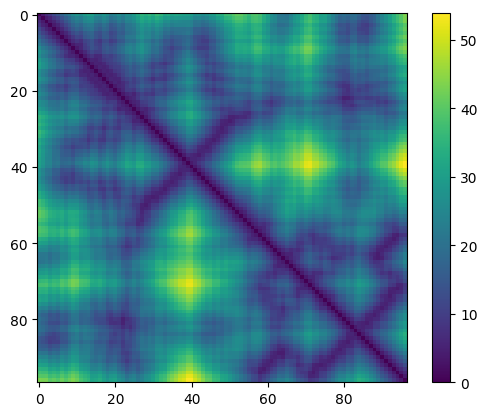

94
torch.Size([94, 20])
HeteroData(
  res={
    x=[94, 20],
    batch=[94],
  },
  positions={ x=[94, 256] },
  godnode={ x=[1, 5] },
  godnode4decoder={ x=[1, 5] },
  (res, backbone, res)={ edge_index=[2, 93] },
  (res, backbone_rev, res)={ edge_index=[2, 93] },
  (godnode4decoder, informs, res)={ edge_index=[2, 94] },
  (res, informs, godnode4decoder)={ edge_index=[2, 94] },
  (res, informs, godnode)={ edge_index=[2, 94] }
)
torch.Size([8836])
tensor([[-3.3522, -3.8718, -5.4844,  ..., -3.5425, -2.8987, -1.7585],
        [-3.5132, -3.8959, -5.5956,  ..., -3.5794, -3.1709, -1.5955],
        [-1.8640, -2.3508, -4.1048,  ..., -5.8087, -3.9557, -2.5329],
        ...,
        [-2.4602, -2.9307, -3.8815,  ..., -3.1505, -2.9287, -2.2171],
        [-2.6112, -3.1404, -4.5913,  ..., -3.6725, -3.2797, -1.7172],
        [-3.4209, -3.3122, -2.7073,  ..., -7.0462, -5.7856, -5.7715]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor([[1.0000e+00, 1.0000e+00, 1.0000e+00,  ..., 1.2478e-16

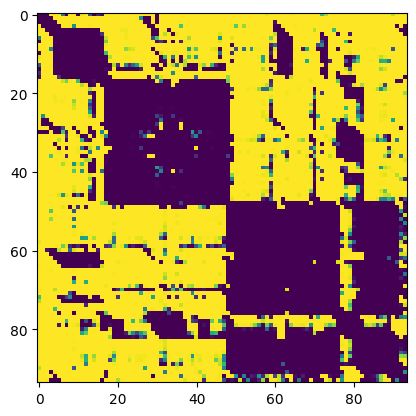

torch.Size([94, 94])
(97, 97)


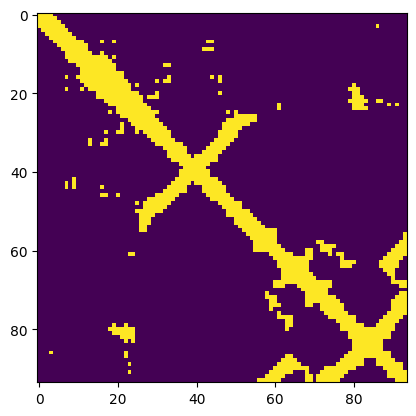

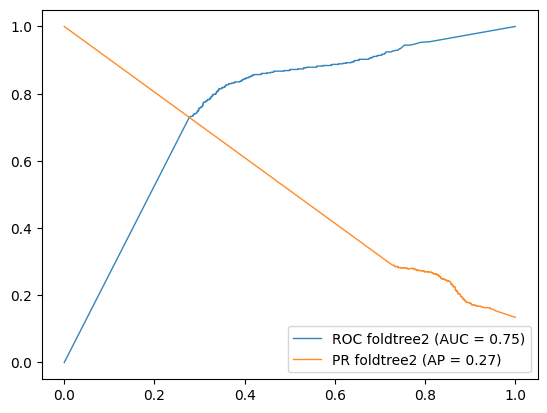

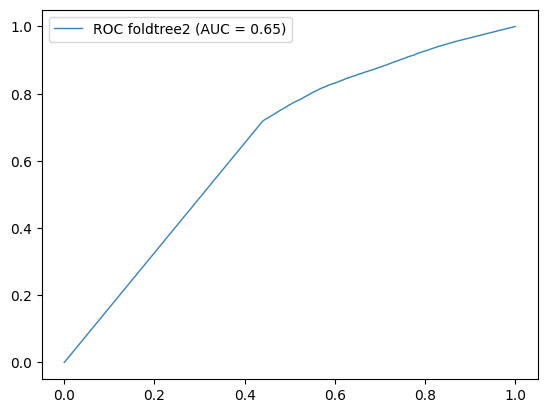

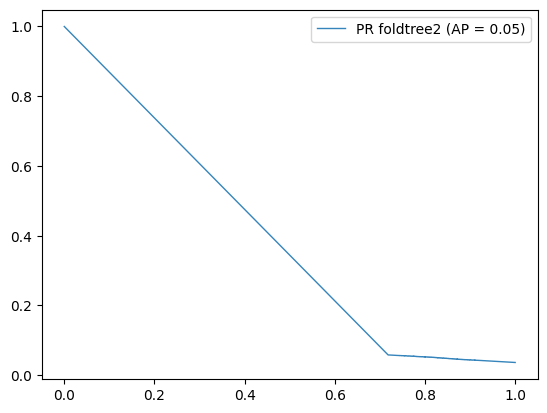

In [72]:
from Bio import PDB
from Bio.PDB import PDBParser
from sklearn.metrics import roc_curve, auc , precision_recall_curve, average_precision_score
from scipy import sparse
import torch_geometric

def get_alpha_carbon_distance_matrix(pdb_file):
	"""
	Extracts the alpha carbon (Cα) atoms from a PDB structure
	and computes the distance matrix in numpy format.

	Parameters:
	pdb_file (str): Path to the PDB file.

	Returns:
	numpy.ndarray: A matrix of distances between all Cα atoms.
	"""
	# Initialize the PDB parser
	parser = PDBParser(QUIET=True)
	
	# Parse the structure
	structure = parser.get_structure('structure', pdb_file)
	
	# Extract alpha carbon (Cα) atoms
	ca_atoms = []
	for model in structure:
		for chain in model:
			for residue in chain :
				if 'CA' in residue and PDB.is_aa(residue) :
					ca_atoms.append(residue['CA'])
	
	# Get the number of Cα atoms
	num_atoms = len(ca_atoms)
	
	# Initialize the distance matrix
	dist_matrix = np.zeros((num_atoms, num_atoms))
	
	# Compute the distances between all pairs of Cα atoms
	for i, atom_i in enumerate(ca_atoms):
		for j, atom_j in enumerate(ca_atoms):
			if i < j:
				dist_matrix[i, j] = atom_i - atom_j
	dist_matrix += dist_matrix.T
	return dist_matrix

#get aa and contacts
def get_backbone(naa):
	backbone_mat = np.zeros((naa, naa))
	backbone_rev_mat = np.zeros((naa, naa))
	np.fill_diagonal(backbone_mat[1:], 1)
	np.fill_diagonal(backbone_rev_mat[:, 1:], 1)
	return backbone_mat, backbone_rev_mat

def sparse2pairs(sparsemat):
	sparsemat = sparse.find(sparsemat)
	return np.vstack([sparsemat[0],sparsemat[1]])

def decoder_reconstruction2aa( ords , device, verbose = False):
	decoder.eval()
	z = encoder.vector_quantizer.embeddings( ords  ).to('cpu')
	print( z.shape)
	edge_index = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	godnode_index = np.vstack([np.zeros(z.shape[0]), [ i for i in range(z.shape[0]) ] ])
	godnode_rev = np.vstack([ [ i for i in range(z.shape[0]) ] , np.zeros(z.shape[0]) ])
	#generate a backbone for the decoder
	data = HeteroData()
	data['res'].x = z
	backbone, backbone_rev = get_backbone( z.shape[0] )
	backbone = sparse.csr_matrix(backbone)
	backbone_rev = sparse.csr_matrix(backbone_rev)
	backbone = sparse2pairs(backbone)
	backbone_rev = sparse2pairs(backbone_rev)
	positional_encoding = converter.get_positional_encoding( z.shape[0] , 256 )
	data['res'].batch = torch.tensor([0 for i in range(z.shape[0])], dtype=torch.long)
	data['positions'].x = torch.tensor( positional_encoding, dtype=torch.float32)
	data['res','backbone','res'].edge_index = torch.tensor(backbone,  dtype=torch.long )
	data[ 'res' , 'backbone_rev' , 'res'].edge_index = torch.tensor(backbone_rev, dtype=torch.long)
	#add the godnode
	data['godnode'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder'].x = torch.tensor(np.ones((1,5)), dtype=torch.float32)
	data['godnode4decoder', 'informs', 'res'].edge_index = torch.tensor(godnode_index, dtype=torch.long)
	data['res', 'informs', 'godnode4decoder'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	data['res', 'informs', 'godnode'].edge_index = torch.tensor(godnode_rev, dtype=torch.long)
	edge_index = edge_index.to( device )
	print( data )
	data = data.to( device )
	allpairs = torch.tensor( [ [i,j] for i in range(z.shape[0]) for j in range(z.shape[0]) ]  , dtype = torch.long).T
	recon_x , edge_probs , zgodnode , foldxout , r, t, angles= decoder( data , allpairs ) 
	print( edge_probs.shape)
	amino_map = decoder.amino_acid_indices
	revmap_aa = { v:k for k,v in amino_map.items() }
	edge_probs = edge_probs.reshape((z.shape[0], z.shape[0]))
	if verbose == True:
		print( recon_x )
		print( edge_probs )
	aastr = ''.join(revmap_aa[int(idx.item())] for idx in recon_x.argmax(dim=1) )
	return aastr ,edge_probs

postives = []
predictions = []
for ex in range( encoded_df.shape[0] ):
	os.makedirs('tmp', exist_ok=True)
	example = encoded_df.iloc[ex]
	protid = encoded_df.index[ex]
	ords = example['ord']
	print( str(protid))
	AFDB_tools.grab_struct(str(protid) , structfolder='tmp/')
	#show struct
	view_custom_pdb('tmp/' + protid + '.pdb', chain='A')
	#get alpha carbon distmat with biopython
	s = get_alpha_carbon_distance_matrix( 'tmp/' + protid + '.pdb')
	#threshold the distance matrix
	plt.imshow(s)
	plt.colorbar()
	plt.show()
	#these are the embedding indices. shift by 1 to get the hex indices
	ords = torch.tensor([ c-1 if c not in rev_replace_dict_ord else rev_replace_dict_ord[c]-1 for c in ords] , dtype=torch.long)
	print( len(ords))
	ords = ords.to(device)	
	aa, edgeprobs = decoder_reconstruction2aa( ords , device = device, verbose = True)
	print(aa)
	#change range of image to 0-1
	probs = 1-edgeprobs.detach().cpu()
	probs = (probs + probs.T)/2
	plt.imshow(probs) 
	plt.show()
	print( probs.shape)
	print( s.shape)
	#output ROC curve for contact prediction

	pos = np.zeros( s.shape )
	pos[ s < 10] = 1
	pos = pos[ 0:probs.shape[0], 0:probs.shape[1]]
	plt.imshow(pos)
	plt.show()

	postives.append(pos.flatten())
	predictions.append(probs.flatten())

	#flatten the matrices
	pos = pos.flatten()
	probs = probs.flatten()
	fpr, tpr, thresholds = roc_curve(pos, 1-probs)
	roc_auc = auc(fpr, tpr)
	plt.plot(fpr, tpr, lw=1, alpha=0.9, label='ROC foldtree2 (AUC = %0.2f)' % (roc_auc))

	#output precision recall curve
	precision, recall, thresholds = precision_recall_curve(pos, 1-probs)
	average_precision = average_precision_score(pos, 1-probs)
	plt.plot(recall, precision, lw=1, alpha=0.9, label='PR foldtree2 (AP = %0.2f)' % (average_precision))
	plt.legend()
	plt.show()

#output ROC curve for contact prediction
postives = np.concatenate(postives)
predictions = np.concatenate(predictions)
fpr, tpr, thresholds = roc_curve(postives, 1-predictions)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, lw=1, alpha=0.9, label='ROC foldtree2 (AUC = %0.2f)' % (roc_auc))
plt.legend()
plt.show()

#output precision recall curve
precision, recall, thresholds = precision_recall_curve(postives, 1-predictions)
average_precision = average_precision_score(postives, 1-predictions)
plt.plot(recall, precision, lw=1, alpha=0.9, label='PR foldtree2 (AP = %0.2f)' % (average_precision))
plt.legend()
plt.show()


In [73]:
# Function to compute Root Mean Square Deviation (RMSD)
def compute_rmsd(coords1, coords2):
    """
    Compute the Root Mean Square Deviation (RMSD) between two sets of coordinates.
    
    Parameters:
    - coords1: Nx3 NumPy array of true coordinates
    - coords2: Nx3 NumPy array of predicted coordinates
    
    Returns:
    - RMSD value
    """
    assert coords1.shape == coords2.shape, "Coordinate arrays must have the same shape"
    
    diff = coords1 - coords2
    rmsd = np.sqrt(np.mean(np.sum(diff**2, axis=1)))
    return rmsd

# Function to compute Local Distance Difference Test (lDDT)
def compute_lddt(true_coords, pred_coords, cutoff=15.0):
    """
    Compute the Local Distance Difference Test (lDDT) score.
    
    Parameters:
    - true_coords: Nx3 NumPy array of true coordinates
    - pred_coords: Nx3 NumPy array of predicted coordinates
    - cutoff: Distance threshold for considering a pair of residues
    
    Returns:
    - lDDT score (0 to 1)
    """
    assert true_coords.shape == pred_coords.shape, "Coordinate arrays must have the same shape"

    num_residues = true_coords.shape[0]
    num_pairs = 0
    num_matching_pairs = 0

    for i in range(num_residues):
        for j in range(i + 1, num_residues):
            true_dist = np.linalg.norm(true_coords[i] - true_coords[j])
            pred_dist = np.linalg.norm(pred_coords[i] - pred_coords[j])

            if true_dist < cutoff:
                num_pairs += 1
                if abs(true_dist - pred_dist) < 0.5 * true_dist:
                    num_matching_pairs += 1

    lddt_score = num_matching_pairs / num_pairs if num_pairs > 0 else 0
    return lddt_score

# Compute RMSD and lDDT
rmsd_value = compute_rmsd(true_coords_from_rt, pred_coords_from_rt)
lddt_value = compute_lddt(true_coords_from_rt, pred_coords_from_rt)

rmsd_value, lddt_value


NameError: name 'true_coords_from_rt' is not defined

In [83]:

#plot the true and predicted structures
def transform_rt_to_coordinates(rotations, translations):
    """
    Given a list of rotation matrices (R) and translation vectors (t),
    generate the global 3D coordinates of the protein backbone.
    
    Parameters:
    - rotations: List of 3x3 rotation matrices
    - translations: List of 3x1 translation vectors
    
    Returns:
    - coords: Nx3 NumPy array representing the backbone in 3D space
    """
    num_residues = len(rotations)
    assert num_residues == len(translations), "Rotation and translation lists must be the same length"
    
    # Initialize the first coordinate at the origin
    coords = [np.array([0, 0, 0, 1])]  # Homogeneous coordinates

    # Apply transformations iteratively
    current_transform = np.eye(4)  # Identity matrix as starting point

    for R, t in zip(rotations, translations):
        # Construct the transformation matrix (4x4)
        T = np.eye(4)
        T[:3, :3] = R
        T[:3, 3] = t
        
        # Update the cumulative transformation
        current_transform = current_transform @ T
        
        # Transform the point and store the new coordinates
        new_point = current_transform @ np.array([0, 0, 0, 1])  # Homogeneous coordinates
        coords.append(new_point)

    return np.array(coords)[:, :3]  # Convert back to 3D coordinates (drop the homogeneous coordinate)


def plot_protein_structures_with_thicker_lines(true_coords, pred_coords):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot true structure with thicker lines and transparency
    ax.plot(true_coords[:, 0], true_coords[:, 1], true_coords[:, 2], 
            'bo-', alpha=0.5, label='True Structure', linewidth=3, markersize=6)

    # Plot predicted structure with thicker lines and transparency
    ax.plot(pred_coords[:, 0], pred_coords[:, 1], pred_coords[:, 2], 
            'ro-', alpha=0.5, label='Predicted Structure', linewidth=3, markersize=6)

    # Adjusted arrow size
    arrow_size = 0.15  # Keep small arrows

    # Add arrowheads to indicate backbone direction
    for i in range(len(true_coords) - 1):
        ax.quiver(true_coords[i, 0], true_coords[i, 1], true_coords[i, 2],
                  true_coords[i+1, 0] - true_coords[i, 0], 
                  true_coords[i+1, 1] - true_coords[i, 1], 
                  true_coords[i+1, 2] - true_coords[i, 2],
                  color='blue', alpha=0.5, arrow_length_ratio=arrow_size)

    for i in range(len(pred_coords) - 1):
        ax.quiver(pred_coords[i, 0], pred_coords[i, 1], pred_coords[i, 2],
                  pred_coords[i+1, 0] - pred_coords[i, 0], 
                  pred_coords[i+1, 1] - pred_coords[i, 1], 
                  pred_coords[i+1, 2] - pred_coords[i, 2],
                  color='red', alpha=0.5, arrow_length_ratio=arrow_size)

    # Labels and legend
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')
    ax.set_title('True vs Predicted Protein Backbone Structure with Thicker Lines')
    ax.legend()

    plt.show()

# Plot with thicker lines
plot_protein_structures_with_thicker_lines(true_coords, noisy_pred_coords)


NameError: name 'true_coords' is not defined